In [1]:
import warnings
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from IPython.display import HTML, display
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
from scipy.stats import skew

warnings.filterwarnings('ignore')

sns.set()

In [2]:
import pandas as pd
data = pd.read_csv('labeled_dataset_axaggpdsc.csv')

## EDA : Exploratory Data Analysis :

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
index                              1000 non-null int64
Age                                983 non-null float64
Prime mensuelle                    989 non-null float64
Categorie socio professionnelle    1000 non-null object
Kilometres parcourus par mois      1000 non-null int64
Coefficient bonus malus            1000 non-null int64
Type de vehicule                   1000 non-null object
Score CRM                          1000 non-null int64
Niveau de vie                      1000 non-null int64
Marque                             948 non-null object
Salaire annuel                     1000 non-null int64
Score credit                       1000 non-null int64
Cout entretien annuel              1000 non-null int64
Benefice net annuel                1000 non-null float64
dtypes: float64(3), int64(8), object(3)
memory usage: 109.5+ KB


**Les variables categoriques:**

Nous pouvons voir à première vue que la catégorie socio-professionnelle, le type de véhicule et la marque représente des variables catégoriques.

In [4]:
for col in data.columns:
    print("Le nombre d'élément dans la colonne "+col+' : '+str(len(data[col].unique())))

Le nombre d'élément dans la colonne index : 1000
Le nombre d'élément dans la colonne Age : 73
Le nombre d'élément dans la colonne Prime mensuelle : 66
Le nombre d'élément dans la colonne Categorie socio professionnelle : 5
Le nombre d'élément dans la colonne Kilometres parcourus par mois : 571
Le nombre d'élément dans la colonne Coefficient bonus malus : 85
Le nombre d'élément dans la colonne Type de vehicule : 4
Le nombre d'élément dans la colonne Score CRM : 107
Le nombre d'élément dans la colonne Niveau de vie : 940
Le nombre d'élément dans la colonne Marque : 7
Le nombre d'élément dans la colonne Salaire annuel : 917
Le nombre d'élément dans la colonne Score credit : 635
Le nombre d'élément dans la colonne Cout entretien annuel : 372
Le nombre d'élément dans la colonne Benefice net annuel : 1000


Il est possible dans la suite du traitement de la data de générer d'autes variables catégoriques à partir des variables numériques comme par exemple définir des intervalles pour l'age ou le salaire annuel.

**Les variables numériques:**

In [5]:
print("La description pour les variables numériques : ")
data.describe()

La description pour les variables numériques : 


,index,Age,Prime mensuelle,Kilometres parcourus par mois,Coefficient bonus malus,Score CRM,Niveau de vie,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel
count,1000.000000,983.000000,989.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.953204,18.754297,605.675000,100.008000,134.724000,4207.239000,29553.820000,493.933000,792.998000,16.975844
std,288.819436,17.985224,13.162842,232.394446,14.854379,20.389791,2665.071559,18054.980164,288.958869,99.422638,19.436137
min,0.000000,0.000000,0.000000,200.000000,50.000000,79.000000,-558.000000,880.000000,1.000000,520.000000,-35.720831
25%,249.750000,26.000000,9.000000,411.000000,90.000000,121.000000,2335.000000,16795.000000,237.000000,726.000000,5.991101
50%,499.500000,32.000000,16.000000,614.000000,100.000000,134.000000,3652.500000,25955.000000,493.500000,794.000000,14.386086
75%,749.250000,42.000000,25.000000,807.000000,110.000000,147.000000,5491.250000,38067.500000,731.750000,863.000000,30.344179
max,999.000000,198.000000,80.000000,999.000000,154.000000,254.000000,23673.000000,165760.000000,999.000000,1145.000000,78.114678


**Observations préliminaires :**

- Tout d'abord il faut éliminer la colonne index de notre analyse. Elle contient des valeurs distinctes et qualitativement non pas de relation avec le bénéfice annuel.

- Il faut, dans un premier temps, examiner la corrélation entre les différentes variables.

- Pour le traitement des variables catégoriques, Je vais leur appliquer un get_dummies.

- Pour le traitement des variables numériques, il faut observer leur distribution et voir si je peux leur appliquer des transformations comme l'application d'une fonction log par exemple.

- Je constate aussi que pour ce dataset il y a quelques valeurs manquantes au niveau des colonnes age, prime mensuelle et marque. Une des méthodes pour palier ce problèmes serait tout simplement d'enlever les lignes qui correspondent à ces valeurs manquantes. D'une manière plus générale, il faut explorer en détails la distribution des valeurs pour chacune des colonnes et suggérer une méthode pour remplir les valeurs manquantes à partir des valeurs dont on dispose.




In [6]:
data.dropna(inplace=True)

### Matrice de corrélation  :

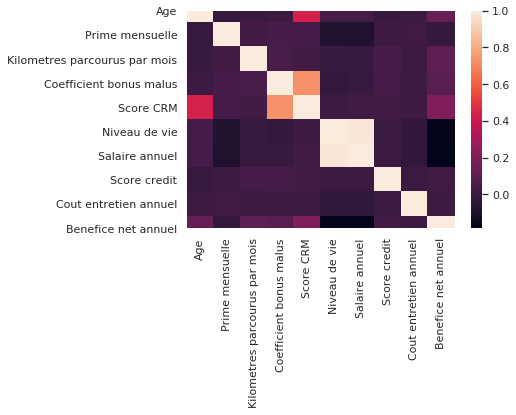

In [7]:
data.drop(columns='index',inplace=True)
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Nous pouvons constater qu'il y a une forte corrélation entre la variable niveau de vie et salaire annuel. Il faudrait donc enlever une des colonnes lors de l'entrainement du modèle. je choisis de supprimer la colonne niveau de vie.

In [8]:
data.drop(columns=['Niveau de vie'],inplace=True)

### Prétraitement sur les variables numériques :

In [9]:
def plot_dist(data,col_name,fct=None):
    fig, ax = plt.subplots(figsize=(20, 5))
    if fct==None :
        sns.distplot(data.dropna()[col_name], ax=ax, label=col_name)
        print("Le degré de la distorition de la variable (Skewness) :",round(data.dropna()[col_name].skew(),3))
        print("Le coefficient d'étalement de la variable (Kurtosis) :",round(data.dropna()[col_name].kurt(),3))
    else : 
        sns.distplot(fct(data.dropna()[col_name]), ax=ax, label=col_name)
        print("Le degré de la distorition de la variable (Skewness) :",round(data.dropna()[col_name].apply(lambda x : fct(x)).skew(),3))
        print("Le coefficient d'étalement de la variable (Kurtosis) :",round(data.dropna()[col_name].apply(lambda x : fct(x)).kurt(),3))
    plt.title('Distribution de la colonne '+col_name)
    plt.legend()


**Paramètres à observer:**
- Le degré de la distorsion et le coefficient d'étalement renseignent sur la symétrie de la distribution et la répartition des valeurs. Le fait d'avoir un degré de distorsion et un facteur d'étalement élévés peut révéler la présence d'outliers qui peuvent affecter le résultat de la prédiction. Nous souhaitons avoir un degré de distorsion proche de 0 qui traduit une certaine symétrie de la courbe par rapport à la moyenne et une valeur du coefficient d'étalement inférieur à un seuil.Lorsqu'on observe une valeur élevée du degré de distorsion, il est possible d'appliquer la fonction logarithme qui permet de rendre la courbe plus symétrique (diminuer le degré de distorsion).

- Pour determiner la présence d'outlier, nous allons recourir à la fonction boxplot qui permet de voir la zone de répartition des valeurs.

#### Distribution de la colonne age :

Le degré de la distorition de la variable (Skewness) : 3.915
Le coefficient d'étalement de la variable (Kurtosis) : 27.348


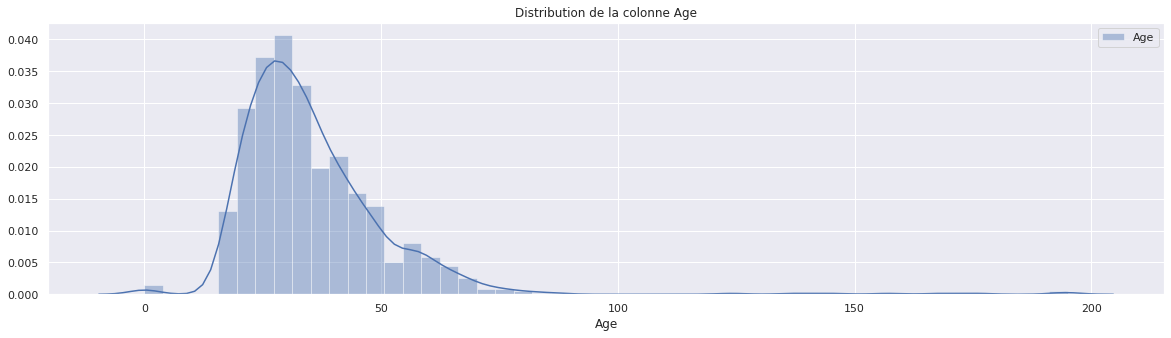

In [10]:
plot_dist(data,'Age')

Observation de la répartition des échatillons pour la colonne Age :


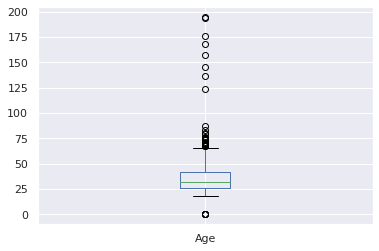

In [11]:
print('Observation de la répartition des échatillons pour la colonne Age :')
data.boxplot(column=['Age']);

**Observations :**
- Nous constatons qu'il y a une forte inclinaison par rapport à la moyenne ( valeur de distorsion élevée) et un coeeficient d'étalement important.

- Selon le box plot, on constate la présence d'outliers qui s'éloigne fortement de la zone où la data est fortement répartie. Nous prendrons les clients dont l'age est entre 10 et 90 ans.

In [12]:
data = data[(data["Age"]<90) &(data["Age"]>10)]

Le degré de la distorition de la variable (Skewness) : 0.307
Le coefficient d'étalement de la variable (Kurtosis) : -0.478


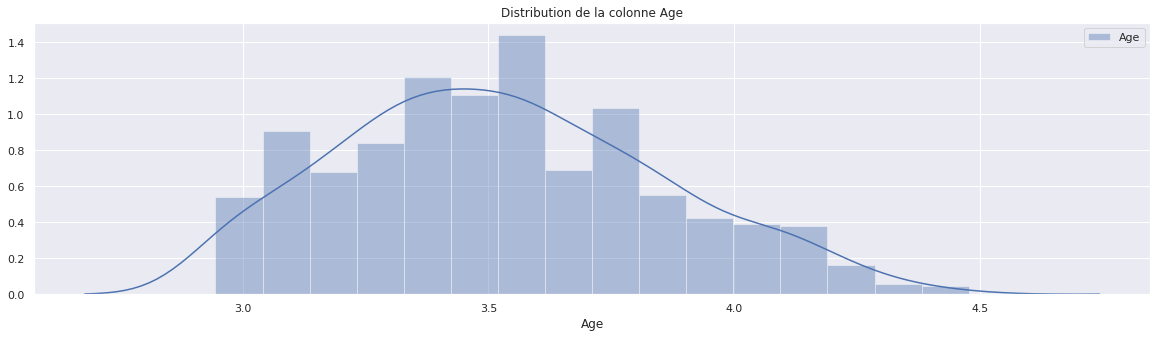

In [13]:
plot_dist(data,'Age',np.log1p)

#### Distribution de la colonne Prime mensuelle :

Le degré de la distorition de la variable (Skewness) : 1.279
Le coefficient d'étalement de la variable (Kurtosis) : 2.059


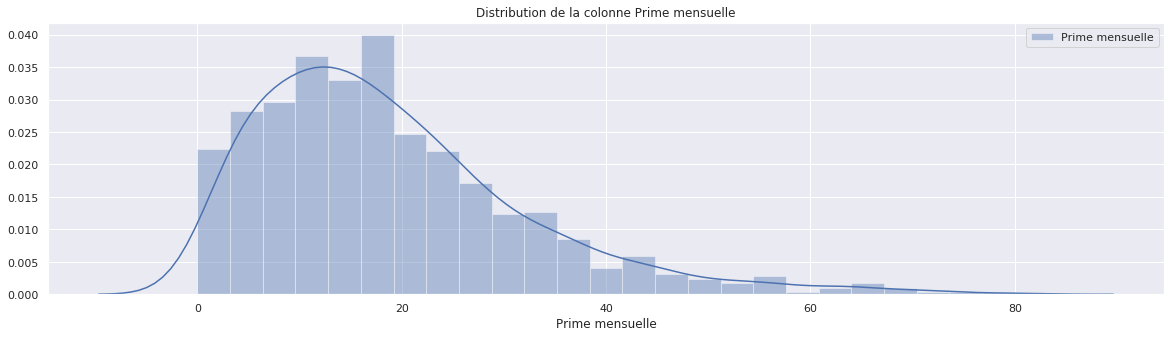

In [14]:
plot_dist(data,'Prime mensuelle')

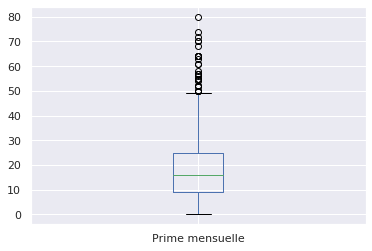

In [15]:
data.boxplot(column=['Prime mensuelle']);

**Observations :**
- Le box plot nous permet d'observer la présence d'outliers situé en dehors de l'intervalle de confiance à 95% ( prime mensuelle à peu près supérieur à 50)
- Le degré de distorsion ainsi que le coefficient d'étalement semble important. L'élimination des outliers permettrait de remédier à ce problème.

In [16]:
data = data[(data["Prime mensuelle"] < 51)].reset_index(drop = True)

Le degré de la distorition de la variable (Skewness) : 0.708
Le coefficient d'étalement de la variable (Kurtosis) : -0.037


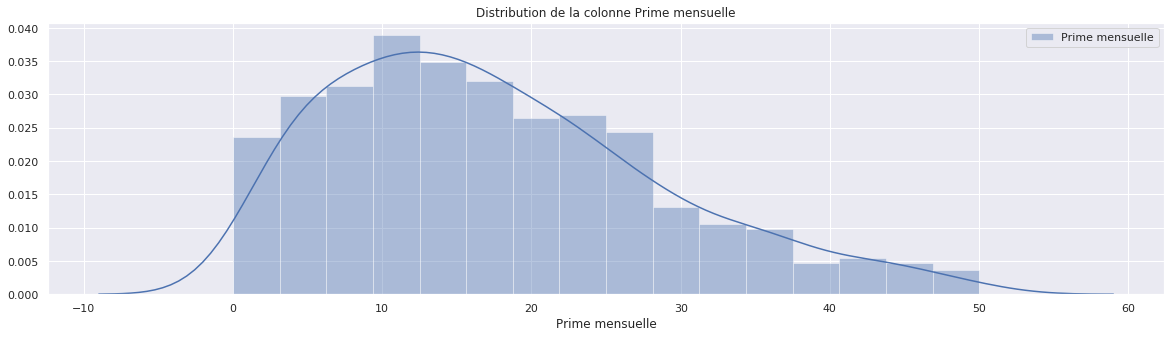

In [17]:
plot_dist(data,'Prime mensuelle')

#### Distribution de la colonne Kilometres parcourus par mois:

Le degré de la distorition de la variable (Skewness) : -0.052
Le coefficient d'étalement de la variable (Kurtosis) : -1.215


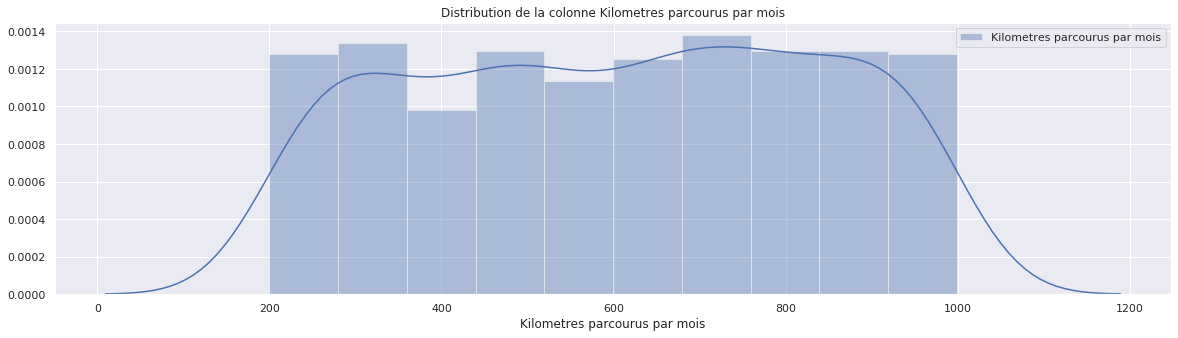

In [18]:
plot_dist(data,'Kilometres parcourus par mois')

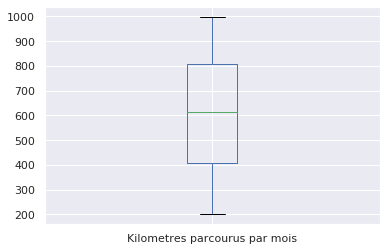

In [19]:
data.boxplot(column=['Kilometres parcourus par mois']);

#### Distribution de la colonne Coefficient bonus malus :

Le degré de la distorition de la variable (Skewness) : -0.069
Le coefficient d'étalement de la variable (Kurtosis) : 0.133


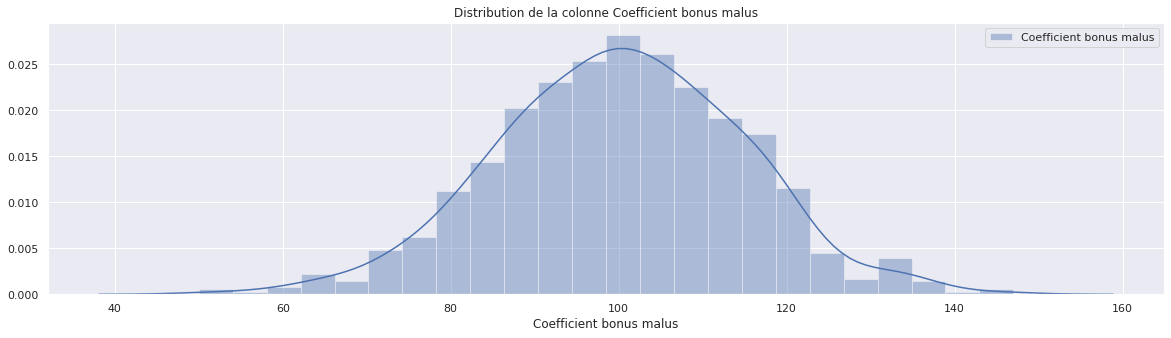

In [20]:
plot_dist(data,'Coefficient bonus malus')

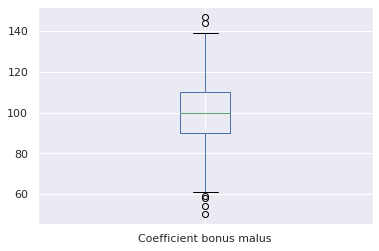

In [21]:
data.boxplot(column=['Coefficient bonus malus']);

#### Distribution de la colonne Score CRM:

Le degré de la distorition de la variable (Skewness) : 0.128
Le coefficient d'étalement de la variable (Kurtosis) : 0.096


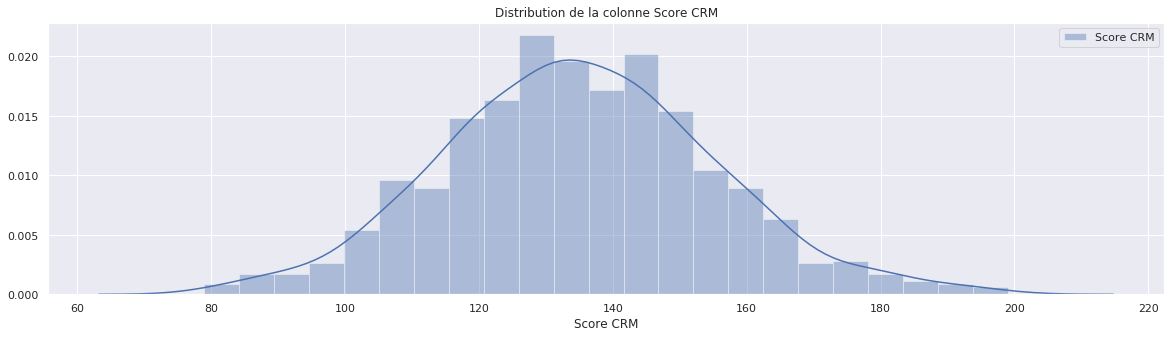

In [22]:
plot_dist(data,'Score CRM')

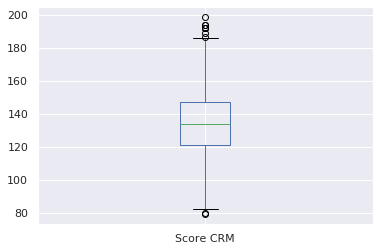

In [23]:
data.boxplot(column=['Score CRM']);

#### Distribution de la colonne Salaire annuel:

Le degré de la distorition de la variable (Skewness) : 1.719
Le coefficient d'étalement de la variable (Kurtosis) : 5.879


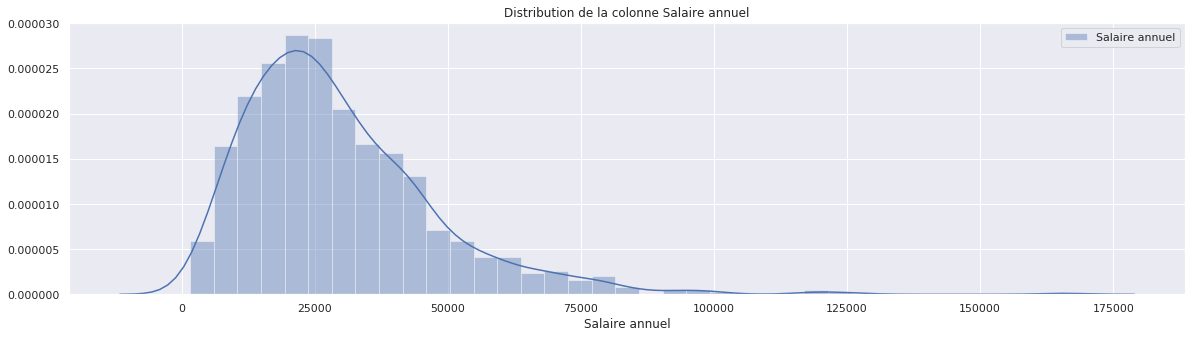

In [24]:
plot_dist(data,'Salaire annuel')

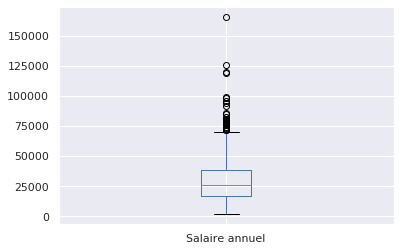

In [25]:
data.boxplot(column=['Salaire annuel']);

**Observations :**

- Nous constatons à partir du box plot la présence d'outliers correspondant à un échantillon de la population avec un salaire annuel plus élevé que 95% de la population. Même si ces valeurs correspondent à des valeurs abérrantes, il est quand même intéressant de les garder vu leur impact sur le benefice net annuel ( en moyenne )

- Je dresse ci-dessous la distribution du bénéfice net annuel correspondant à la tranche de population avec un salaire annuel supérieur à 75000€ (On constate qu'en moyenne, on n'a pas de gain). Comparé à la tranche de la population avec un salaire < 75000€ (on constate qu'en moyenne, on a un gain de 15 unités).

- Le fait d'ôter ces valeurs entrainera une interférence sur la politique de pricing.

- Pour limiter l'impact des outliers, j'ai décidé d'appliquer la fonction logarithmique.

Le degré de la distorition de la variable (Skewness) : 0.788
Le coefficient d'étalement de la variable (Kurtosis) : 0.804


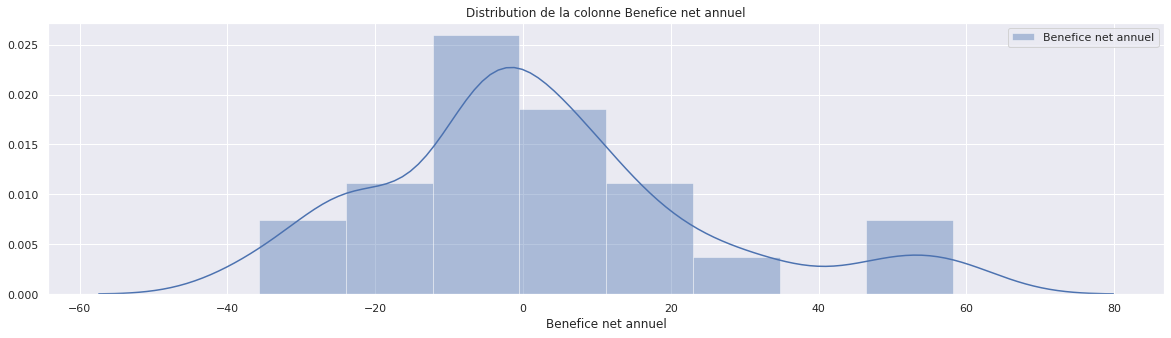

In [26]:
plot_dist(data[data['Salaire annuel']>75000],'Benefice net annuel')

Le degré de la distorition de la variable (Skewness) : 0.306
Le coefficient d'étalement de la variable (Kurtosis) : 0.018


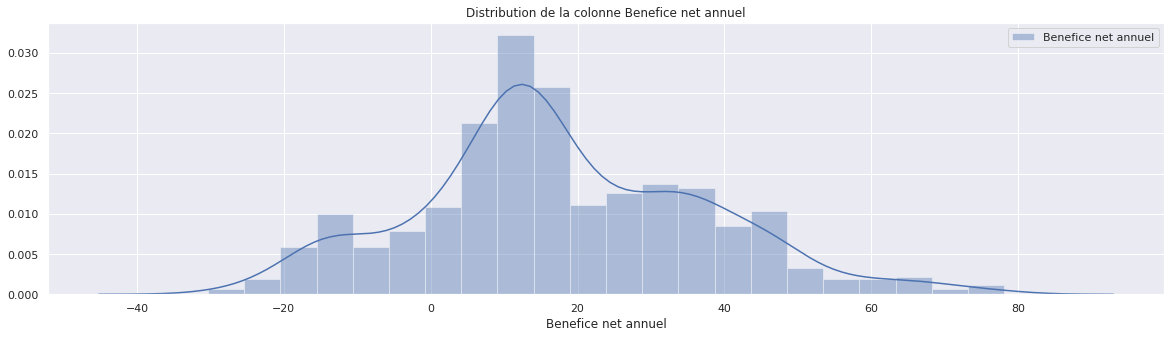

In [27]:
plot_dist(data[data['Salaire annuel']<75000],'Benefice net annuel')

In [28]:
data['Log Salaire annuel']=np.log(data['Salaire annuel'])

Le degré de la distorition de la variable (Skewness) : -0.493
Le coefficient d'étalement de la variable (Kurtosis) : 0.576


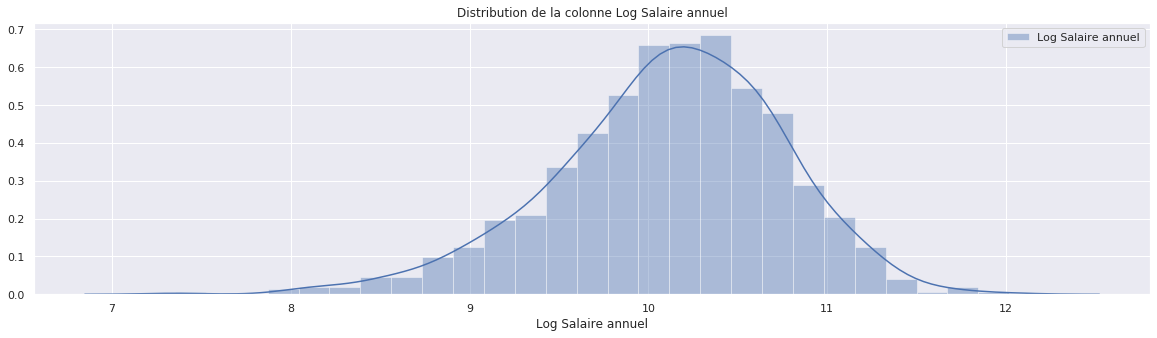

In [29]:
plot_dist(data,'Log Salaire annuel')

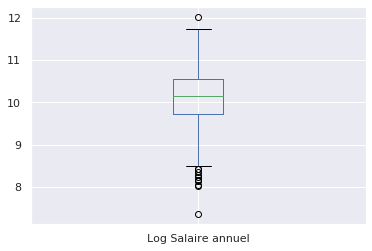

In [30]:
data.boxplot(column=['Log Salaire annuel']);

#### Distribution de la colonne Score credit:

Le degré de la distorition de la variable (Skewness) : 0.022
Le coefficient d'étalement de la variable (Kurtosis) : -1.227


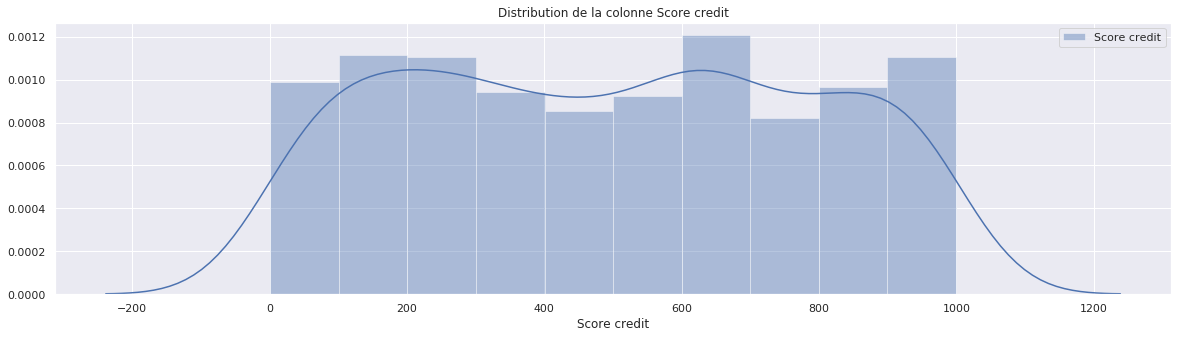

In [31]:
plot_dist(data,'Score credit')

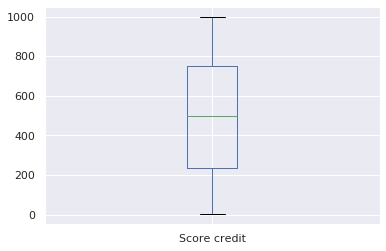

In [32]:
data.boxplot(column='Score credit')

#### Distribution de la colonne Cout entretien annuel:

Le degré de la distorition de la variable (Skewness) : -0.014
Le coefficient d'étalement de la variable (Kurtosis) : -0.07


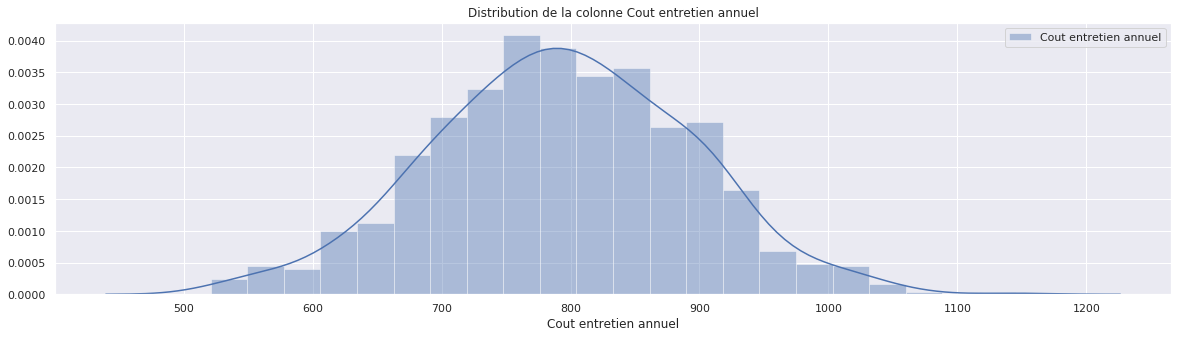

In [33]:
plot_dist(data,'Cout entretien annuel')

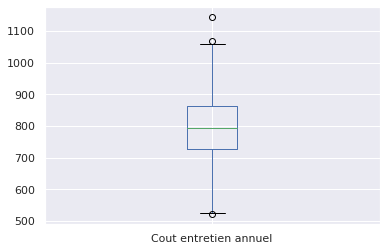

In [34]:
data.boxplot(column='Cout entretien annuel')

### Prétraitement sur les variables catégoriques :

In [35]:
def plot_categorical_variables(data, column):
    # Figure Size
    fig, ax = plt.subplots(figsize=(9,6))

    # Horizontal Bar Plot
    title_cnt=data[column].value_counts().sort_values(ascending=False).reset_index()
    mn= ax.barh(title_cnt.iloc[:,0], title_cnt.iloc[:,1], color=sns.color_palette('Reds',len(title_cnt)))




    # Remove axes splines
    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 
    ax.invert_yaxis()

    # Add Plot Title
    ax.set_title('Most frequent ' +str(column),weight='bold',
                 loc='center', pad=10, fontsize=16)
    ax.set_xlabel('Count', weight='bold')


    # Add annotation to bars
    for i in ax.patches:
        ax.text(i.get_width()+1, i.get_y()+0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')
    plt.yticks(weight='bold')


    plt.show()
    # Show Plot
    plt.show()

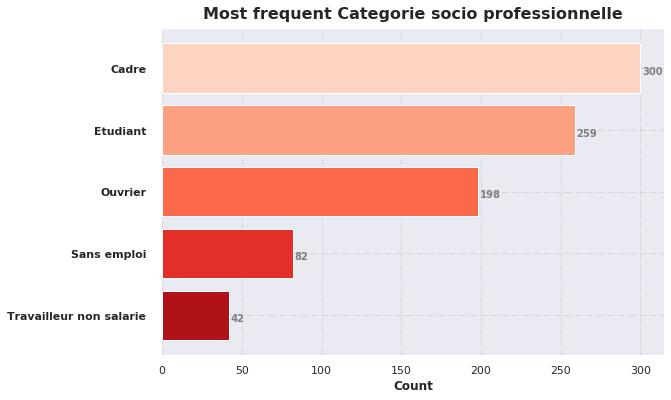

In [36]:
plot_categorical_variables(data,'Categorie socio professionnelle')

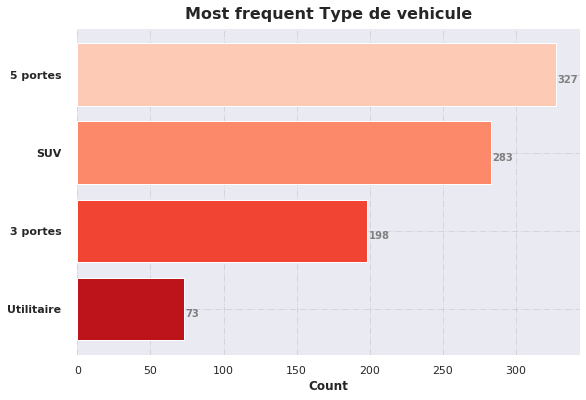

In [37]:
plot_categorical_variables(data,'Type de vehicule')

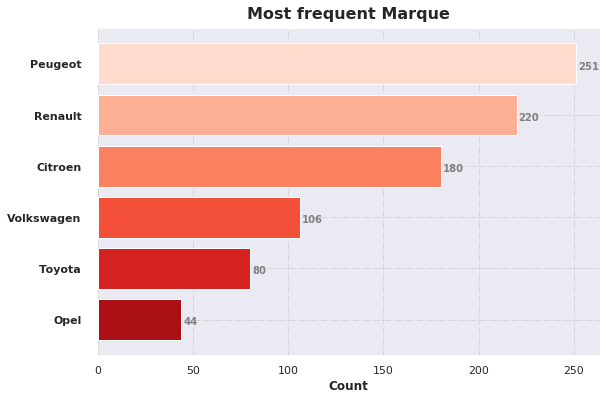

In [38]:
plot_categorical_variables(data,'Marque')

In [39]:
categorical_features = ['Categorie socio professionnelle',
                        'Type de vehicule', 'Marque']
data = pd.get_dummies(data=data, columns=categorical_features)

In [40]:
data.head()

,Age,Prime mensuelle,Kilometres parcourus par mois,Coefficient bonus malus,Score CRM,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel,Log Salaire annuel,...,Type de vehicule_3 portes,Type de vehicule_5 portes,Type de vehicule_SUV,Type de vehicule_Utilitaire,Marque_Citroen,Marque_Opel,Marque_Peugeot,Marque_Renault,Marque_Toyota,Marque_Volkswagen
0,58.0,40.0,973,106,164,20420,309,801,54.998558,9.924270,...,0,0,1,0,0,0,1,0,0,0
1,26.0,27.0,637,95,126,25750,135,667,7.840930,10.156190,...,0,1,0,0,0,0,0,1,0,0
2,27.0,26.0,978,136,153,6790,786,696,46.078889,8.823206,...,0,0,1,0,0,0,0,1,0,0
3,22.0,8.0,771,96,111,15140,320,765,-11.048213,9.625096,...,1,0,0,0,0,0,1,0,0,0
4,60.0,20.0,758,101,149,12850,287,808,1.180078,9.461099,...,1,0,0,0,0,0,1,0,0,0


## Feature extractor :

In [41]:
def feature_extractor_train_validation(data):
    data.dropna(inplace=True)
    data.drop(columns=['index','Niveau de vie'],inplace=True)
    data = data[(data["Age"]<90) &(data["Age"]>10)]
    data['Age'] = np.log1p(data['Age'])
    data = data[(data["Prime mensuelle"] < 51)].reset_index(drop = True)
    data['Salaire annuel']=np.log1p(data['Salaire annuel'])
    categorical_features = ['Categorie socio professionnelle',
                        'Type de vehicule', 'Marque']
    data = pd.get_dummies(data=data, columns=categorical_features)
    return data

In [42]:
def feature_extractor_test(data):
    data.drop(columns=['index','Niveau de vie'],inplace=True)
    for col in data.columns[data.isna().any()].tolist():
        try:
            data[col] = data[col].fillna(int(data[col].median()))
        except:
            continue
    data['Age'] = np.log1p(data['Age'])
    data['Salaire annuel']=np.log1p(data['Salaire annuel'])
    categorical_features = ['Categorie socio professionnelle',
                        'Type de vehicule', 'Marque']
    data = pd.get_dummies(data=data, columns=categorical_features)
    return data

## Entrainement du modèle :

**Démarche à suivre:**

- Afin de faire une bonne évaluation du modèle nous devons diviser notre data en train et validation.

- Nous appliquerons le feature extractor sur chacun des jeu de données

- D'une manière générale, suivant la nature du modèle qu'on utilise, nous ferons une normalisation de notre data 

- Il faudrait faire le tuning des hyperparamètres du modèle qu'on va entrainer.


In [43]:
data = pd.read_csv('labeled_dataset_axaggpdsc.csv')
y = data['Benefice net annuel']

X_train, X_test = train_test_split(
    data, test_size=0.1, random_state=0)

In [44]:
X_train = feature_extractor_train_validation(X_train)
X_test = feature_extractor_train_validation(X_test)

y_train = X_train['Benefice net annuel']
y_test = X_test['Benefice net annuel']

X_train = X_train.drop(columns=['Benefice net annuel'])
X_test = X_test.drop(columns=['Benefice net annuel'])

selected_columns = np.intersect1d(X_train.columns, X_test.columns)
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [45]:
stdscaler = StandardScaler()
X_train = stdscaler.fit_transform(X_train)
X_test = stdscaler.transform(X_test)

Pour l'entrainement du modèle je propose trois types de modèles:
- modèle de regression linéaire une approche classique (Souvent utilisée pour ce type de problématique)
- Random forest pour la regression qui est une approche d'apprentissage ensembliste qui repose sur le principe de bootstrap aggregation (bagging)
- Xgboost pour la regression qui est une apporche d'apprentissage ensembliste qui repose sur le principe de boosting.

In [46]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [47]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)
y_pred_LR_test = model.predict(X_test)
y_pred_LR_train = model.predict(X_train)

In [48]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

rms_train = sqrt(mean_squared_error(y_train, y_pred_LR_train))
r2_train = r2_score(y_train,y_pred_LR_train)
gini_index_LR_train = gini(y_pred_LR_train)
print('RMSE train : ',rms_train)
print('R2 score train : ',r2_train)
print('Indice GINI train : ',gini_index_LR_train)
print('#####################################')
rms_test = sqrt(mean_squared_error(y_test, y_pred_LR_test))
r2_test = r2_score(y_test,y_pred_LR_test)
gini_index_LR_test = gini(y_pred_LR_test)
print('RMSE test : ',rms_test)
print('R2 score test : ',r2_test)
print('Indice GINI test : ',gini_index_LR_test)

RMSE train :  6.6661636711656636
R2 score train :  0.8861356897390251
Indice GINI train :  0.2600898958302128
#####################################
RMSE test :  6.371899576627456
R2 score test :  0.8864050682191794
Indice GINI test :  0.32581636072067927


In [49]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train,y_train)
y_pred_RF_test = model.predict(X_test)
y_pred_RF_train = model.predict(X_train)

In [50]:
rms_train = sqrt(mean_squared_error(y_train, y_pred_RF_train))
r2_train = r2_score(y_train,y_pred_RF_train)
gini_index_RF_train = gini(y_pred_RF_train)
print('RMSE train : ',rms_train)
print('R2 score train : ',r2_train)
print('Indice GINI train : ',gini_index_RF_train)
print('#####################################')
rms_test = sqrt(mean_squared_error(y_test, y_pred_RF_test))
r2_test = r2_score(y_test,y_pred_RF_test)
gini_index_RF_test = gini(y_pred_RF_test)
print('RMSE test : ',rms_test)
print('R2 score test : ',r2_test)
print('Indice GINI test : ',gini_index_RF_test)

RMSE train :  1.3502272251535856
R2 score train :  0.9953285748351748
Indice GINI train :  0.23076023309009633
#####################################
RMSE test :  2.8623253086186287
R2 score test :  0.9770776525481661
Indice GINI test :  0.24171802653586233


In [51]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train,y_train)
y_pred_XGBR_test = model.predict(X_test)
y_pred_XGBR_train = model.predict(X_train)

[23:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
rms_train = sqrt(mean_squared_error(y_train, y_pred_XGBR_train))
r2_train = r2_score(y_train,y_pred_XGBR_train)
gini_index_XGBR_train = gini(y_pred_XGBR_train)
print('RMSE train : ',rms_train)
print('R2 score train : ',r2_train)
print('Indice GINI train : ',gini_index_XGBR_train)
print('#####################################')
rms_test = sqrt(mean_squared_error(y_test, y_pred_XGBR_test))
r2_test = r2_score(y_test,y_pred_XGBR_test)
gini_index_XGBR_test = gini(y_pred_XGBR_test)
print('RMSE test : ',rms_test)
print('R2 score test : ',r2_test)
print('Indice GINI test : ',gini_index_XGBR_test)

RMSE train :  1.397444573692732
R2 score train :  0.9949961433675241
Indice GINI train :  0.21808486450645448
#####################################
RMSE test :  2.1672042798165907
R2 score test :  0.9868592301417878
Indice GINI test :  0.27370989153573966


**Observations :**
- Nous constatons à partir de ces valeurs que le modèle Xgboost permet d'obtenir une meilleur performance en terme de perte et un bon indice d'impureté.

**Remarque :**
- La determination des valeurs optimaux des paramètres risquerait de prendre un certain temps lors de l'entrainement. c'est pour cettre raison que je ne l'ai pas détaillé ici. Pour la faire, il faudrait faire un gridsearch sur une plage de valeur des paramètres qu'on défit au préalable.

In [53]:
train = pd.read_csv('labeled_dataset_axaggpdsc.csv') 
test = pd.read_csv('scoring_dataset_axaggpdsc.csv')

In [54]:
train = feature_extractor_train_validation(train)
test = feature_extractor_test(test)
y_train = train['Benefice net annuel']

selected_columns = np.intersect1d(train.columns, test.columns)
train = train[selected_columns]
test = test[selected_columns]

In [55]:
def train_predict(model,train,y_train,test):
    model.fit(train,y_train)
    y_pred_XGBR_test = model.predict(test)
    return y_pred_XGBR_test

In [56]:
y_pred_XGBR_test = train_predict(XGBRegressor(),train,y_train,test)

[23:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [57]:
indexes = test.index
final_result = pd.DataFrame({'index':indexes,'prediction':y_pred_XGBR_test})

In [58]:
final_result.to_csv('final_submission.csv')